In [1]:
# settings
force_rerun = False
run_once = False # useful for debugging, just runs one sample

# imports
import os
import sys

# code for enabling this notebook to work within cursor
coralme_dir = '/home/chris/zuniga/coralme/' #'../'
sys.path.insert(0, coralme_dir)

import cobra
import coralme
import coralme.solver.solver
import coralme.builder.main
import coralme.core.model
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from adjustText import adjust_text
from collections import Counter
import math

def get_n_colors_from_colormap(n, colormap_name='viridis'):
    cmap = cm.get_cmap(colormap_name)
    if n == 1:
        return(cmap(1))
    else:
        return [cmap(i / (n - 1)) for i in range(n)]
    
def create_m_to_me_mapping(m_model, me_model):
    """
    Create a dictionary mapping M model reaction IDs to their corresponding ME model reaction IDs
    
    Parameters:
    -----------
    m_model : cobra.Model
        Original M model
    me_model : coralme.core.MEModel
        ME model generated from M model
        
    Returns:
    --------
    dict
        Dictionary with M model reaction IDs as keys and lists of corresponding ME reaction IDs as values
    """
    m_to_me = {}
    
    # For each M model reaction, find corresponding ME reactions
    for m_rxn in m_model.reactions:
        # Find all ME reactions that contain this M reaction ID
        me_rxns = [me_rxn.id for me_rxn in me_model.reactions 
                  if m_rxn.id in me_rxn.id]
        
        if me_rxns:
            m_to_me[m_rxn.id] = me_rxns
            
    return m_to_me

# build pathway reference using other models
files = []
for f in os.listdir(os.path.join(coralme_dir, 'data', 'external', 'pathways')):
    path = os.path.join(coralme_dir, 'data', 'external', 'pathways', f)
    files.append(path)
files.sort()
models_source_df = pd.read_excel(files[0], index_col = 0)
models_source_df['source'] = 'iML1515'
for f in files[1:]:
    df = pd.read_excel(f, index_col = 0)
    df['source'] = f.split('pathways/')[1][2:-4]
    new = set(df.index) - set(models_source_df.index)
    models_source_df = pd.concat([models_source_df, df.loc[list(new)]])

# build pathway reference using Carlos mapping
models_carlos_df = pd.read_csv(os.path.join(coralme_dir, 'data', 'external', 'geneIDsMapping_PA14_vs_Strains_SubsystemInfo.csv'), index_col = 0)

In [2]:
# look for default starting media and annotate pathways
path = os.path.join(coralme_dir, 'data', 'default_model_exchanges.pkl')
if os.path.exists(path):
    pickle_in = open(path, 'rb')
    default_exchanges = pickle.load(pickle_in)
    pickle_in.close()
else:
    default_exchanges = {}

# create EC to pathway mapping
resp = requests.get('https://rest.kegg.jp/link/ec/pathway')
EC_to_pathways = {}
for line in resp.text.split('\n')[:-1]:
    if 'path:ec' in line: continue
    ec = line.split('\t')[1][3:]
    path = line.split('\t')[0][5:]
    if ec not in EC_to_pathways:
        EC_to_pathways.update({ec : set()})
    EC_to_pathways[ec].add(path)

# now create mapping from pathway to name
resp = requests.get('https://rest.kegg.jp/list/pathway')
pathway_to_name = {}
for line in resp.text.split('\n')[:-1]:
    pathway_to_name.update({line.split('\t')[0] : line.split('\t')[1]})

# loop through each model
spec_to_neg_EX = {}
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
for f in os.listdir(os.path.join(base_dir, 'individual_species')):
    if f == 'Reference': continue
        
    # load in ME_model
    out_path = os.path.join(base_dir, 'individual_species', f, 'outputs')
    if not force_rerun and os.path.exists(os.path.join(out_path, 'pathway_annotated_model.pkl')):
        print(str(f)+' : pathway annotated model already created, skipping')
        continue
    out_dict = {}
    opts = os.listdir(out_path)
    model_name = None
    for opt in opts:
        if 'step3' in opt:
            model_name = opt
    if not model_name:
        print(str(f)+' : model doesn\'t exist')
        continue
    print(str(f)+' : loading model...', end = '')
    ME_model = coralme.io.pickle.load_pickle_me_model(os.path.join(out_path, model_name))
    model_path = os.path.join(base_dir, 'individual_species', f, 'inputs', 'model.json')
    M_model = cobra.io.load_json_model(model_path)
    
    # look through exchange reactions to figure out what the media type is
    print('finding media exchanges...', end = '')
    spec_to_neg_EX.update({f : set()})
    for rxn in ME_model.reactions:
        if 'EX_' not in rxn.id:
            continue
        elif rxn.lower_bound < 0:
            spec_to_neg_EX[f].add((rxn.id, rxn.lower_bound, rxn.upper_bound))

    # let's also create subsystem annotations in the ME model
    print('mapping pathways...', end = '')
    mapping = create_m_to_me_mapping(M_model, ME_model)
    mapping_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_to_ME_mapping.pkl')
    pickle_out = open(mapping_path, 'wb')
    pickle.dump(mapping, pickle_out)
    pickle_out.close()
    
    for M_rxn, ME_rxns in mapping.items():
        if 'ec-code' not in M_model.reactions.get_by_id(M_rxn).annotation: continue
        pathways = set()
        for ec_code in M_model.reactions.get_by_id(M_rxn).annotation['ec-code']:
            if ec_code not in EC_to_pathways: continue
            pathways = pathways.union(EC_to_pathways[ec_code])
        pathways = list(pathways)
        pathways.sort()
        for rxn in ME_rxns:
            ME_model.reactions.get_by_id(rxn).annotation.update({'EC_id_pathways' : pathways})

    # let's also create subsystem annotations in the ME model using the reference organisms
    for M_rxn, ME_rxns in mapping.items():
        if M_rxn not in models_source_df.index: continue
        sub = models_source_df.loc[M_rxn].Subsystem
        source = models_source_df.loc[M_rxn].source 
        for ME_rxn in ME_rxns:
            ME_rxn = ME_model.reactions.get_by_id(ME_rxn)
            ME_rxn.annotation.update({'ref_pathways' : sub})
            ME_rxn.annotation.update({'ref_pathways_source' : source})
    
    # let's also pass along the GPR rules and add Carlos gene mapping for subsystems
    for M_rxn, ME_rxns in mapping.items():
        M_rxn = M_model.reactions.get_by_id(M_rxn)
        for ME_rxn in ME_rxns:
            ME_model.reactions.get_by_id(ME_rxn).annotation.update({'genes' : set(M_rxn.gpr.genes)})
            subs = set()
            for gene in M_rxn.gpr.genes:
                check = models_carlos_df[models_carlos_df[f] == gene]
                if len(check) == 0: continue
                sub = check.Subsystem.values[0]
                subs.add(sub)
            subs = list(subs)
            subs.sort()
            ME_model.reactions.get_by_id(ME_rxn).annotation.update({'carlos_pathways' : subs})
        
    # now let's save the ME model with the annotations
    print('saving model...', end = '')
    coralme.io.pickle.save_pickle_me_model(ME_model, os.path.join(out_path, 'pathway_annotated_model.pkl'))
    print(' done!')
    if run_once:
        break

# save off changes
pickle_out = open(path, 'wb')
pickle.dump(default_exchanges, pickle_out)
pickle_out.close()

CP008896 : pathway annotated model already created, skipping
CP053697 : pathway annotated model already created, skipping
CP026386 : pathway annotated model already created, skipping
CP069317 : pathway annotated model already created, skipping
AE004091.2 : pathway annotated model already created, skipping
CP014784 : pathway annotated model already created, skipping
CP073105 : pathway annotated model already created, skipping
CP065866 : pathway annotated model already created, skipping
CP061848 : pathway annotated model already created, skipping
CP012831 : pathway annotated model already created, skipping
CP008749.1 : pathway annotated model already created, skipping
CP032419 : pathway annotated model already created, skipping
CP038001 : pathway annotated model already created, skipping
CP022560 : pathway annotated model already created, skipping
CP076683 : pathway annotated model already created, skipping
CP045416 : pathway annotated model already created, skipping
AP022324 : pathway a

In [3]:
# check for solutions, run if nonexistant
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
for f in os.listdir(os.path.join(base_dir, 'individual_species')):
    if 'Reference' in f: continue
    
    # look to see if solution already exists
    sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_solution.pkl')
    M_sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_flux_solution.pkl')
    M_flux_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_flux_ref_solution_dict.pkl')
    flux_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_EC_solution_dict.pkl')
    flux_path2 = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_ref_solution_dict.pkl')
    if not force_rerun and os.path.exists(sol_path) and os.path.exists(M_sol_path) and os.path.exists(flux_path) and os.path.exists(flux_path2):
        print(str(f)+' : already run')
        continue
    if not force_rerun or not os.path.exists(os.path.join(out_path, 'pathway_annotated_model.pkl')):
        print(str(f)+' : pathway annotated model does not exist, skipping')
        continue
    print(str(f)+' : working...', end = '')
    
    # run M model simulations
    M_model_path = os.path.join(base_dir, 'individual_species', f, 'inputs', 'model.json')
    if force_rerun or not os.path.exists(M_sol_path):
        print('running M model...', end = '')
        M_model = cobra.io.load_json_model(M_model_path)
        M_sol = M_model.optimize()

        # for now assume there's always a solution until that causes an error
        rxns = []
        fluxes = []
        pathways = []
        for rxn, flux in M_sol.fluxes.items():
            M_rxn = M_model.reactions.get_by_id(rxn)
            # pull out genes to get pathways
            pathways_temp = set()
            for gene in M_rxn.gpr.genes:
                check = models_carlos_df[models_carlos_df[f] == gene]
                if len(check) == 0: continue
                sub = check.Subsystem.values[0]
                pathways_temp.add(sub)
            pathways_temp = list(pathways_temp)
            pathways_temp.sort()

            rxns.append(rxn)
            fluxes.append(flux)
            pathways.append(pathways_temp)

        # make solution dataframe, save it
        flux_df = pd.DataFrame(index = rxns)
        flux_df['flux'] = fluxes
        flux_df['pathways'] = pathways
        flux_df.to_pickle(M_flux_path)
        
        # save off solution
        pickle_out = open(M_sol_path, 'wb')
        pickle.dump(M_sol, pickle_out)
        pickle_out.close()
    
    # run ME model simulations if it doesn't exist
    if force_rerun or not os.path.exists(sol_path):
        print('running ME model...', end = '')
        out_path = os.path.join(base_dir, 'individual_species', f, 'outputs')
        ME_model = coralme.io.pickle.load_pickle_me_model(os.path.join(out_path, 'pathway_annotated_model.pkl'))
        
        # run on this default medium
        solution = ME_model.optimize(max_mu = 0.5, min_mu = 0.01, tolerance = 1e-4, maxIter = 20)
    
        # if there is a solution, create pathway to flux and annotation, save them
        if solution:
            print('saving solution...', end = '')
            rxns = []
            fluxes = []
            pathways = []
            rxns2 = []
            fluxes2 = []
            pathways2 = []
            for rxn, flux in ME_model.solution.fluxes.items():
                ME_rxn = ME_model.reactions.get_by_id(rxn)
                if 'EC_id_pathways' in ME_rxn.annotation:
                    rxns.append(rxn)
                    fluxes.append(flux)
                    pathways.append(ME_rxn.annotation['EC_id_pathways'])
                if 'ref_pathways' in ME_rxn.annotation:
                    rxns2.append(rxn)
                    fluxes2.append(flux)
                    pathways2.append(ME_rxn.annotation['ref_pathways'])
            flux_df = pd.DataFrame(index = rxns)
            flux_df['flux'] = fluxes
            flux_df['pathways'] = pathways
            flux_df.to_pickle(flux_path)
            flux_df2 = pd.DataFrame(index = rxns2)
            flux_df2['flux'] = fluxes2
            flux_df2['pathways'] = pathways2
            flux_df2.to_pickle(flux_path2)
        
            # save off solution
            pickle_out = open(sol_path, 'wb')
            pickle.dump(ME_model.solution, pickle_out)
            pickle_out.close()
        else:
            print('no solution...', end = '')
            # save something bogus to prevent rerunning this
            pickle_out = open(flux_path, 'wb')
            pickle.dump(False, pickle_out)
            pickle_out.close()
            pickle_out = open(flux_path2, 'wb')
            pickle.dump(False, pickle_out)
            pickle_out.close()
            
            # save off solution
            pickle_out = open(sol_path, 'wb')
            pickle.dump(False, pickle_out)
            pickle_out.close()
    print(' done!')
    if run_once:
        break

CP008896 : already run
CP053697 : already run
CP026386 : already run
CP069317 : already run
AE004091.2 : already run
CP014784 : already run
CP073105 : already run
CP065866 : already run
CP061848 : already run
CP012831 : already run
CP008749.1 : already run
CP032419 : already run
CP038001 : already run
CP022560 : already run
CP076683 : already run
CP045416 : already run
AP022324 : already run
LS483372 : already run
CP022562 : already run
LR590473 : already run
CP065865 : already run
CP058975 : already run
CP012830 : already run
AP014655.1 : already run
CP061335 : already run
CP068238 : already run
CP050291 : already run
CP070982 : already run
CP000712 : already run
AP024503 : already run
CP045349 : already run
CP063780 : already run
CP024478 : already run
CP022561 : already run
CP065867 : already run
CP020100 : already run
CP039749 : already run
CP041013 : already run
CP015225 : already run
CP045359 : already run
CP043320 : already run
CP060288 : already run
CP043179 : already run


CP014784 : no solution, skipping
AP022324 : no solution, skipping
CP058975 : no solution, skipping


/tmp/ipykernel_133/25129072.py:111: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  plt_df = plt_df.dropna(0, how = 'all').fillna(0)
/tmp/ipykernel_133/1010894669.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap_name)


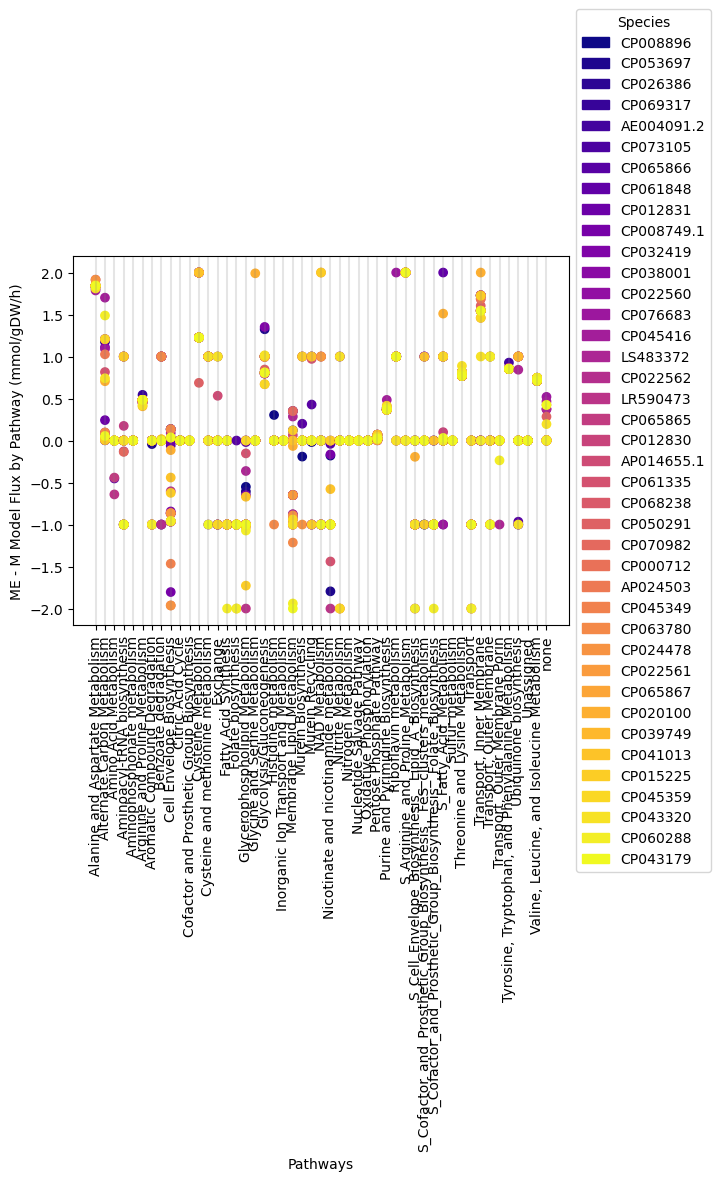

How often labelled:
CP008749.1 : 28
AE004091.2 : 26
LR590473 : 26
CP065865 : 26
CP076683 : 25
CP041013 : 25
CP008896 : 24
CP022562 : 24
CP061335 : 24
CP068238 : 24
CP070982 : 24
AP024503 : 24
CP045349 : 24
CP063780 : 24
CP039749 : 24
CP015225 : 24
CP065866 : 23
CP061848 : 23
CP038001 : 23
CP012830 : 23
CP000712 : 23
CP022561 : 23
CP065867 : 23
CP020100 : 23
CP043320 : 23
CP060288 : 23
CP043179 : 23
LS483372 : 22
CP050291 : 22
CP024478 : 22
CP053697 : 21
CP026386 : 21
CP073105 : 21
CP032419 : 21
AP014655.1 : 21
CP045359 : 21
CP069317 : 20
CP012831 : 20
CP022560 : 20
CP045416 : 19


In [49]:
# plotting
opts = list(set(models_carlos_df.Subsystem))

# let's loop through all of these to pull out flux_dfs
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
plt_df = pd.DataFrame(index = opts)
total_df = pd.DataFrame(index = opts)
for f in os.listdir(os.path.join(base_dir, 'individual_species')):
    if 'Reference' in f: continue
    
    # look to see if solution already exists
    M_sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_flux_solution.pkl')
    M_flux_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_flux_ref_solution_dict.pkl')
    ME_sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_solution.pkl')
    ME_flux_path= os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_ref_solution_dict.pkl')
    tot_paths = [M_sol_path, M_flux_path, ME_sol_path, ME_flux_path]
    if not all([os.path.exists(path) for path in tot_paths]):# not os.path.exists(sol_path) or not os.path.exists(M_sol_path) or not os.path.exists(flux_path) or not os.path.exists(flux_path2):
        print(str(f)+' : not yet run')
        continue
    
    # load in results
    pickle_in = open(M_sol_path, 'rb')
    M_sol = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open(M_flux_path, 'rb')
    M_flux_df = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open(ME_sol_path, 'rb')
    ME_sol = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open(ME_flux_path, 'rb')
    ME_flux_df = pickle.load(pickle_in)
    pickle_in.close()
    mapping_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_to_ME_mapping.pkl')
    pickle_in = open(mapping_path, 'rb')
    M_to_ME = pickle.load(pickle_in)
    pickle_in.close()

    # check if solutions exist
    if not ME_sol or not M_sol:
        print(str(f)+' : no solution, skipping')
        continue
    
    # create combined Dataframe standardized by growth rates
    rxns = []
    M_fluxes = []
    ME_sum_fluxes = []
    ME_abs_sum_fluxes = []
    pathways = []
    for M_rxn, ME_rxns in M_to_ME.items():
        if not all([rxn in ME_flux_df.index for rxn in ME_rxns]):
            continue
        overlap = [rxn for rxn in ME_rxns if rxn in ME_flux_df.index]
        M_flux = M_flux_df.loc[M_rxn]['flux'] / M_sol.objective_value
        ME_flux = ME_flux_df.loc[overlap]['flux'] / ME_sol.objective_value
        for pathway in M_flux_df.loc[M_rxn]['pathways']:
            rxns.append(M_rxn)
            M_fluxes.append(M_flux)
            ME_sum_fluxes.append(sum(ME_flux.values))
            ME_abs_sum_fluxes.append(sum(abs(ME_flux.values)))
            pathways.append(pathway)
    summed_df = pd.DataFrame(index = rxns)
    summed_df['M_fluxes'] = M_fluxes
    summed_df['sum_abs_ME_fluxes'] = ME_abs_sum_fluxes
    summed_df['sum_ME_fluxes'] = ME_sum_fluxes
    summed_df['pathways'] = pathways

    # now convert to pathway summed flux for plotting
    # copying from https://www.nature.com/articles/s41467-020-17612-8
    groups = []
    M_scores = []
    ME_scores = []
    for group, df in summed_df.groupby('pathways'):
        if sum(abs(df['M_fluxes'])) == 0:
            M_score = 0
        else:
            M_score = sum(df['M_fluxes']) / sum(abs(df['M_fluxes']))
        if sum(df['sum_abs_ME_fluxes']) == 0:
            ME_score = 0
        else:
            ME_score = sum(df['sum_ME_fluxes']) / sum(df['sum_abs_ME_fluxes'])
        groups.append(group)
        M_scores.append(M_score)
        ME_scores.append(ME_score)
    plot_df = pd.DataFrame(index = groups)
    plot_df['M_score'] = M_scores
    plot_df['ME_score'] = ME_scores
    plot_df[f] = plot_df['ME_score'] - plot_df['M_score']
    plt_df = plt_df.join(plot_df[f], how='left')
    total_df = total_df.join(plot_df.rename(columns = {'M_score' : 'M_'+f, 'ME_score' : 'ME_'+f}), how = 'left')

    ################################################
    # individual plot #
    ################################################
    diff_groups = plot_df.index[plot_df['M_score'] != plot_df['ME_score']]
    show_df = plot_df.loc[diff_groups]
    x_vals = [i for i in range(len(show_df.index))]
    plt.scatter(x_vals, show_df['M_score'], c = 'red', label = 'M model')
    plt.scatter(x_vals, show_df['ME_score'], c = 'blue', label = 'ME model')
    plt.xticks(np.arange(0, max(x_vals)+1), show_df.index, rotation = 90)
    plt.xlabel('Pathways')
    plt.ylabel('Flux by Pathway (mmol/gDW/h)')
    plt.title('Strain: '+f)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('../figures/strain_figures/'+f+'_flux_figure.pdf', transparent = True, bbox_inches="tight")
    plt.close()
total_df.to_csv('../data/summed_flux_df.csv')

################################################
# overall plot #
################################################
plt_df = plt_df.dropna(0, how = 'all').fillna(0)
keep = [any([val not in [-1, 0, 1] for val in vals]) for vals in plt_df.values] # remove samples that contain only -1s, 0s, and 1s
plt_df = plt_df.loc[keep].sort_index()

colors = get_n_colors_from_colormap(len(plt_df.columns), 'plasma')
col_to_colors = {col : color for col, color in zip(plt_df.columns, colors)}
colors = []
x_vals = []
y_vals = []
labels = []
labels_long = []
i = 0
for index in plt_df.index:
    labels.append(index)
    for col in plt_df.columns:
        val = plt_df.loc[index][col]
        x_vals.append(i)
        y_vals.append(val)
        labels_long.append(col)
        colors.append(col_to_colors[col])
    i += 1
fig, ax = plt.subplots()
sorted_x = list(set(x_vals))
sorted_x.sort()
for x in sorted_x:
    plt.axvline(x = x, c = 'grey', alpha = 0.2)
plt.scatter(x_vals, y_vals, c = colors)
plt.xticks(np.arange(0, max(x_vals)+1), labels, rotation = 90)
plt.xlabel('Pathways')
plt.ylabel('ME - M Model Flux by Pathway (mmol/gDW/h)')

# label the "outliers"
x_labs = []
y_labs = []
labs = []
for x_val, y_val, lab_temp in zip(x_vals, y_vals, labels_long):
    if abs(y_val) > 0.05:
        x_labs.append(x_val)
        y_labs.append(y_val)
        labs.append(lab_temp)
if len(labs) < 50:
    texts = [ax.text(x_labs[i], y_labs[i], labs[i], ha='center', va='center') for i in range(len(x_labs))]
    _ = adjust_text(texts, expand=(1.2, 1.2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
                arrowprops=dict(arrowstyle='->', color='k')); # ensure the labeling is clear by adding arrows);

# Custom legend using patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in col_to_colors.items()]
plt.legend(handles=legend_patches, title='Species', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(os.path.join(coralme_dir, 'figures', 'pathway_flux.pdf'), transparent = True, bbox_inches="tight")
plt.show()

# most commonly outlier
print('How often labelled:')
label_to_ct = dict(Counter(labs))
sorted_labels = [k for k, _ in sorted(label_to_ct.items(), key = lambda k : -k[1])]
for k in sorted_labels:
    print(str(k)+' : '+str(label_to_ct[k]))

# old version

/tmp/ipykernel_133/1260272403.py:69: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  pathways_df = pathways_df.dropna(0, how = 'all')
/tmp/ipykernel_133/1010894669.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap_name)


38 [-0.67252886 -0.56286833]
41 [ 0.01570142 -0.54996811]


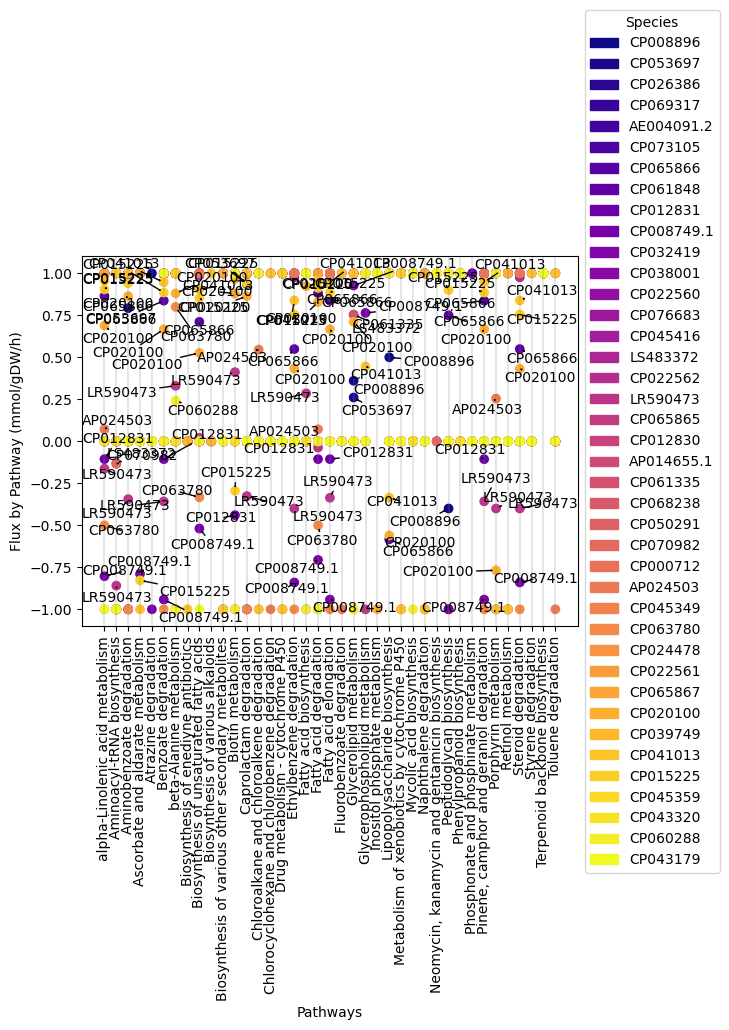

How often labelled:
CP020100 : 16
LR590473 : 13
CP015225 : 13
CP008749.1 : 11
CP065866 : 10
CP041013 : 8
CP012831 : 6
AP024503 : 4
CP063780 : 4
CP053697 : 3
CP008896 : 3
LS483372 : 2
CP070982 : 1
CP060288 : 1
CP061335 : 1


In [6]:
# plotting
use_flux = 1
pathways_df = pd.DataFrame(index = pathway_to_name.keys())

# let's loop through all of these to pull out flux_dfs
base_dir = os.path.join(coralme_dir, 'species_files', 'Pseudomonas_files')
for f in os.listdir(os.path.join(base_dir, 'individual_species')):
    if 'Reference' in f: continue
    
    # look to see if solution already exists
    sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_solution.pkl')
    M_sol_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_flux_solution.pkl')
    M_flux_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'M_flux_ref_solution_dict.pkl')
    flux_path = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_EC_solution_dict.pkl')
    flux_path2 = os.path.join(base_dir, 'individual_species', f, 'outputs', 'flux_ref_solution_dict.pkl')
    tot_paths = [sol_path, M_sol_path, M_flux_path, flux_path, flux_path2]
    if not all([os.path.exists(path) for path in tot_paths]):# not os.path.exists(sol_path) or not os.path.exists(M_sol_path) or not os.path.exists(flux_path) or not os.path.exists(flux_path2):
        print(str(f)+' : not yet run')
        continue
    
    # load in results
    pickle_in = open(sol_path, 'rb')
    sol = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open(flux_path, 'rb')
    flux_df = pickle.load(pickle_in)
    pickle_in.close()
    pickle_in = open(flux_path2, 'rb')
    flux_df2 = pickle.load(pickle_in)
    pickle_in.close()
    if type(flux_df) == bool or len(flux_df) == 0:
        continue
    
    # reorganize by pathway groups
    pathway_to_fluxes = {}
    if use_flux == 1:
        for index, row in flux_df.iterrows():
            pathways = row['pathways']
            if str(pathways) == 'nan': continue
            for pathway in pathways:
                if pathway not in pathway_to_fluxes:
                    pathway_to_fluxes.update({pathway : []})
                pathway_to_fluxes[pathway].append(row['flux'])
    else:
        for index, row in flux_df2.iterrows():
            pathway = row['pathways']
            if str(pathways) == 'nan': continue
            if pathway not in pathway_to_fluxes:
                pathway_to_fluxes.update({pathway : []})
            pathway_to_fluxes[pathway].append(row['flux'])
    
    # take max of each to represent the flux through the map (not sure what the best strategy is, maybe manually pick bottlenecks?)
    vals = []
    for pathway in pathways_df.index:
        if pathway in pathway_to_fluxes:
            # copying from https://www.nature.com/articles/s41467-020-17612-8
            total = sum(pathway_to_fluxes[pathway])
            abs_total = sum([abs(val) for val in pathway_to_fluxes[pathway]])
            if abs_total == 0:
                vals.append(0)
            else:
                vals.append(total / abs_total)
        else:
            vals.append(None)
    pathways_df[f] = vals

# now we can plot
pathways_df = pathways_df.rename(pathway_to_name).sort_index(key = lambda ind : ind.str.lower())
pathways_df = pathways_df.dropna(0, how = 'all')
keep = pathways_df.index[abs(pathways_df).sum(axis = 1) != 0] # remove examples where all zero
pathways_df = pathways_df.loc[keep]
keep = pathways_df.index[abs(pathways_df).sum(axis = 1) != len(pathways_df.columns)] # remove examples of all 1s or all -1s
pathways_df = pathways_df.loc[keep]
keep = [any([val not in [-1, 0, 1] for val in vals]) for vals in pathways_df.values] # remove samples that contain only -1s, 0s, and 1s
pathways_df = pathways_df.loc[keep]

colors = get_n_colors_from_colormap(len(pathways_df.columns), 'plasma')
col_to_colors = {col : color for col, color in zip(pathways_df.columns, colors)}
colors = []
x_vals = []
y_vals = []
labels = []
labels_long = []
i = 0
for index in pathways_df.index:
    labels.append(index)
    for col in pathways_df.columns:
        val = pathways_df.loc[index][col]
        x_vals.append(i)
        y_vals.append(val)
        labels_long.append(col)
        colors.append(col_to_colors[col])
    i += 1
fig, ax = plt.subplots()
sorted_x = list(set(x_vals))
sorted_x.sort()
for x in sorted_x:
    plt.axvline(x = x, c = 'grey', alpha = 0.2)
plt.scatter(x_vals, y_vals, c = colors)
plt.xticks(np.arange(0, max(x_vals)+1), labels, rotation = 90)
plt.xlabel('Pathways')
plt.ylabel('Flux by Pathway (mmol/gDW/h)')

# label the "outliers"
x_labs = []
y_labs = []
labs = []
for x_val, y_val, lab_temp in zip(x_vals, y_vals, labels_long):
    if abs(y_val) < 0.95 and abs(y_val) > 0.05:
        x_labs.append(x_val)
        y_labs.append(y_val)
        labs.append(lab_temp)
texts = [ax.text(x_labs[i], y_labs[i], labs[i], ha='center', va='center') for i in range(len(x_labs))]
_ = adjust_text(texts, expand=(1.2, 1.2), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle='->', color='k')); # ensure the labeling is clear by adding arrows);

# Custom legend using patches
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in col_to_colors.items()]
plt.legend(handles=legend_patches, title='Species', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(os.path.join(coralme_dir, 'figures', 'pathway_flux.pdf'), transparent = True, bbox_inches="tight")
plt.show()

# most commonly outlier
print('How often labelled:')
label_to_ct = dict(Counter(labs))
sorted_labels = [k for k, _ in sorted(label_to_ct.items(), key = lambda k : -k[1])]
for k in sorted_labels:
    print(str(k)+' : '+str(label_to_ct[k]))